In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import typing as t
from functools import partial

In [2]:
def bootstrap(data: np.ndarray, n: int, func: t.Callable[[np.ndarray], float]) -> np.ndarray:
    """Bootstrap the data."""
    # Data should be a 1D array
    assert data.ndim == 1

    aggregated_data = np.apply_along_axis(
        func, 
        axis=1, 
        arr=np.random.choice(data, size=(n, data.shape[0]), replace=True)
    )

    # Return the mean of the aggregated data
    return aggregated_data

def bootstrap_reduce(data: np.ndarray, n: int, func: t.Callable[[np.ndarray], float]) -> np.ndarray:
    """Bootstrap the data."""
    return bootstrap(data, n, func).mean(axis=0)

In [3]:
df_raw = pd.read_csv(Path('data/kode24_lønn_2023_vår.csv'), sep=',')

# Remove rows where the column "Lønn" is NaN
df_base = df_raw[df_raw['lønn'].notna()]

In [4]:
df_base.head()

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
0,21-25,2.0,5.0,"in-house, privat sektor",Oslo,sikkerhet,100 - 500,350000.0,Ja,Ja
1,26-30,0.0,1.0,"in-house, privat sektor",Innlandet,fullstack,100 - 500,350000.0,Nei,Nei
2,31-35,3.0,14.0,"in-house, privat sektor",Viken,ingen av disse,100 - 500,350000.0,Nei,Nei
3,26-30,NaN,3.0,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,350000.0,Ja,Nei
4,31-35,4.0,0.0,"in-house, privat sektor",Viken,fullstack,under 10,350000.0,Nei,Nei


In [5]:
df_base.describe()

,utdanning,erfaring,lønn
count,2234.000000,2303.000000,2.306000e+03
mean,3.529543,8.832827,8.435237e+05
std,1.738960,7.833926,2.919897e+05
min,0.000000,0.000000,3.500000e+05
25%,3.000000,3.000000,6.500000e+05
50%,3.000000,6.000000,7.900000e+05
75%,5.000000,13.000000,9.600000e+05
max,10.000000,45.000000,3.500000e+06


In [6]:
# Count the number of rows with nans for each column
df_base.isna().sum()

alder         0
utdanning    72
erfaring      3
jobb          0
sted          0
fag           0
kolleger      0
lønn          0
bonus         0
fornøyd       0
dtype: int64

843523.6769297485
843523.6769297485
Diff: 0.0
25th percentile: 650000.0
Median: 790000.0
75th percentile: 960000.0


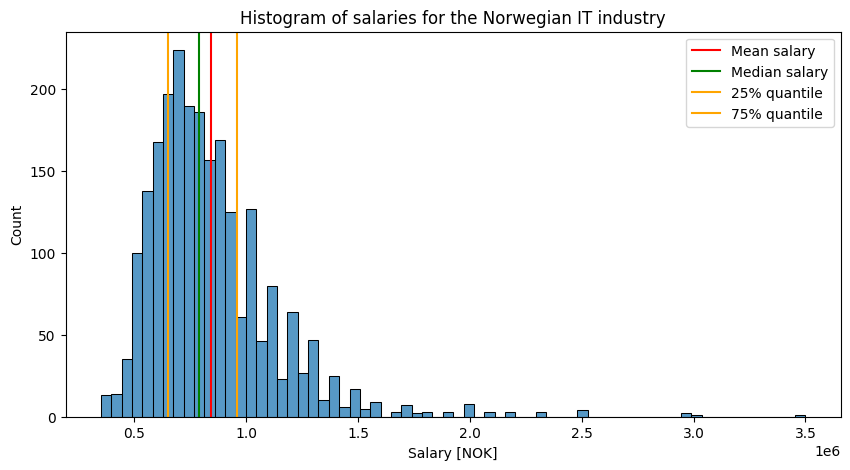

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

df = df_base.copy()

pre_filtered_mean = df['lønn'].mean()

# Remove outliers
# df = df[df['lønn'] < 2_000_000]

# Draw a histogram of the column "lønn"
sns.histplot(df['lønn'], ax=ax)

# Draw a line at the mean.
ax.axvline(df['lønn'].mean(), color='red', label='Mean salary')
ax.axvline(df['lønn'].median(), color='green', label='Median salary')
ax.axvline(df['lønn'].quantile(0.25), color='orange', label='25% quantile')
ax.axvline(df['lønn'].quantile(0.75), color='orange', label='75% quantile')
ax.set(title='Histogram of salaries for the Norwegian IT industry', xlabel='Salary [NOK]', ylabel='Count')
ax.legend()

print(pre_filtered_mean)
print(df['lønn'].mean())
print(f"Diff: {pre_filtered_mean - df['lønn'].mean()}")
print(f"25th percentile: {df['lønn'].quantile(0.25)}")
print(f"Median: {df['lønn'].median()}")
print(f"75th percentile: {df['lønn'].quantile(0.75)}")

Coefficients: [16789.31139814]
Intercept: 695422.2433951539
MSE: 68001910099.13795
RMSE: 260771.75863029715


<Axes: >

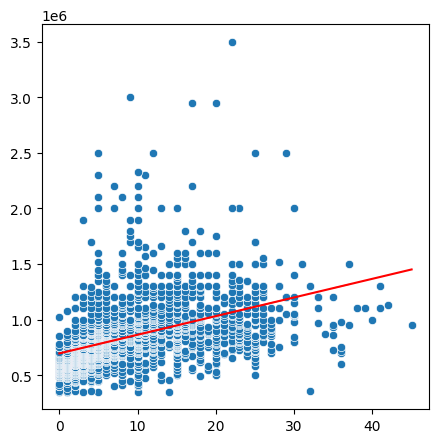

In [39]:
# Import linear regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

df = df_base.copy()

df = df[['lønn', 'erfaring']]
# Remove nan values
df = df.dropna()

# Use the columns to predict lønn.
X = df[['erfaring']].to_numpy()
y = df['lønn'].to_numpy()

# Scale the data
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Create a linear regression model
model = LinearRegression()
model.fit(X, y)

# Print the coefficients and intercept
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

# Calculate the mean squared error
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
print(f'MSE: {mse}')
rmse = mse ** 0.5
print(f'RMSE: {rmse}')

# Plot the predictions
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(x=X[:, 0], y=y, ax=ax)
sns.lineplot(x=X[:, 0], y=y_pred, ax=ax, color='red')

In [31]:


df = df_base.copy()
df = df[['lønn', 'erfaring']]
df = df.dropna()

df = df[df['lønn'] < 2_000_000]
df = df[df['erfaring'] < 25]

X = df[['erfaring']].to_numpy()
y = df['lønn'].to_numpy()

def apply_percentile(data: np.ndarray, percentile: float=50) -> float:
    """Apply a percentile to the data."""
    try:
        return np.percentile(data, percentile)
    except Exception:
        return np.nan

def apply_mean(data: np.ndarray) -> float:
    """Apply a percentile to the data."""
    try:
        return data.mean()
    except Exception:
        return np.nan

# For every year of experience, calculate the mean salary
df_mean = pd.DataFrame({'erfaring': range(int(df['erfaring'].min()), int(df['erfaring'].max()))})
df_mean['lønn'] = df_mean['erfaring'].apply(lambda x: bootstrap_reduce(df[df['erfaring'] == x]['lønn'].to_numpy(), 1000, apply_mean))


Text(0, 0.5, 'Salary [NOK]')

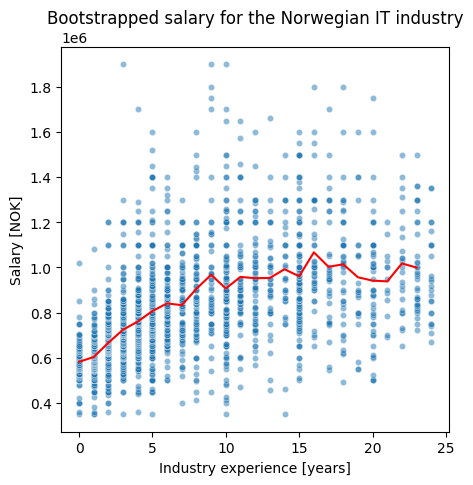

In [32]:
# # Plot the mean salary
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(x=X[:, 0], y=y, ax=ax, alpha=0.5, s=20)
sns.lineplot(x=df_mean['erfaring'], y=df_mean['lønn'], ax=ax, color='red')

ax.set_title('Bootstrapped salary for the Norwegian IT industry')
ax.set_xlabel('Industry experience [years]')
ax.set_ylabel('Salary [NOK]')